In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['export OPENBLAS_NUM_THREADS']='1'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import math
import h5py
import cv2
import glob
from functools import partial
import matplotlib as ml
from PIL import Image
# from models.utils import train, test, LpLoss, get_filter, UnitGaussianNormalizer
from models.utils_3d import train, test, LpLoss, get_filter, UnitGaussianNormalizer

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_initializer(name):
    
    if name == 'xavier_normal':
        init_ = partial(nn.init.xavier_normal_)
    elif name == 'kaiming_uniform':
        init_ = partial(nn.init.kaiming_uniform_)
    elif name == 'kaiming_normal':
        init_ = partial(nn.init.kaiming_normal_)
    return init_

In [6]:
class sparseKernel(nn.Module):
    def __init__(self,
                 k, alpha, c=1, 
                 nl = 1,
                 initializer = None,
                 **kwargs):
        super(sparseKernel,self).__init__()
        
        self.k = k
        self.conv = self.convBlock(alpha*k**2, alpha*k**2)
        self.Lo = nn.Conv1d(alpha*k**2, c*k**2, 1)
        
    def forward(self, x):
        B, c, ich, Nx, Ny, T = x.shape # (B, c, ich, Nx, Ny, T)
        x = x.reshape(B, -1, Nx, Ny, T)
        x = self.conv(x)
        x = self.Lo(x.view(B, c*ich, -1)).view(B, c, ich, Nx, Ny, T)
        return x
        
        
    def convBlock(self, ich, och):
        net = nn.Sequential(
            nn.Conv3d(och, och, 3, 1, 1),
            nn.ReLU(inplace=True),
        )
        return net 
    

def compl_mul3d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    op = partial(torch.einsum, "bixyz,ioxyz->boxyz")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)


# fft conv taken from: https://github.com/zongyi-li/fourier_neural_operator
class sparseKernelFT(nn.Module):
    def __init__(self,
                 k, alpha, c=1, 
                 nl = 1,
                 initializer = None,
                 **kwargs):
        super(sparseKernelFT, self).__init__()        
        
        self.modes = alpha

        self.weights1 = nn.Parameter(torch.zeros(c*k**2, c*k**2, self.modes, self.modes, self.modes, 2))
        self.weights2 = nn.Parameter(torch.zeros(c*k**2, c*k**2, self.modes, self.modes, self.modes, 2))        
        self.weights3 = nn.Parameter(torch.zeros(c*k**2, c*k**2, self.modes, self.modes, self.modes, 2))        
        self.weights4 = nn.Parameter(torch.zeros(c*k**2, c*k**2, self.modes, self.modes, self.modes, 2))        
        nn.init.xavier_normal_(self.weights1)
        nn.init.xavier_normal_(self.weights2)
        nn.init.xavier_normal_(self.weights3)
        nn.init.xavier_normal_(self.weights4)
        
        self.Lo = nn.Conv1d(c*k**2, c*k**2, 1)
#         self.Wo = nn.Conv1d(c*k**2, c*k**2, 1)
        self.k = k
        
    def forward(self, x):
#         print("x.shape before", x.shape)
        B, c, ich, Nx, Ny, T = x.shape # (B, c, ich, N, N, T)
        
        x = x.reshape(B, -1, Nx, Ny, T)
#         print("x.shape ", x.shape)
        x_fft = torch.rfft(x, 3, normalized=True, onesided=True)
        
        # Multiply relevant Fourier modes
        l1 = min(self.modes, Nx//2+1)
#         print("l1 ", l1)
        l2 = min(self.modes, Ny//2+1)
#         print("l2 ", l2)
        out_ft = torch.zeros(B, c*ich, Nx, Ny, T//2 +1, 2, device=x.device)

#         print("out_ft", out_ft.shape)
#         print("x_fft", x_fft.shape)
#         print("self.modes ", self.modes)
#         print("self.weights1 ", self.weights1.shape)
        
        out_ft[:, :, :l1, :l2, :self.modes] = compl_mul3d(
            x_fft[:, :, :l1, :l2, :self.modes], self.weights1[:, :, :l1, :l2, :])
        out_ft[:, :, -l1:, :l2, :self.modes] = compl_mul3d(
                x_fft[:, :, -l1:, :l2, :self.modes], self.weights2[:, :, :l1, :l2, :])
        out_ft[:, :, :l1, -l2:, :self.modes] = compl_mul3d(
                x_fft[:, :, :l1, -l2:, :self.modes], self.weights3[:, :, :l1, :l2, :])
        out_ft[:, :, -l1:, -l2:, :self.modes] = compl_mul3d(
                x_fft[:, :, -l1:, -l2:, :self.modes], self.weights4[:, :, :l1, :l2, :])
        
        #Return to physical space
        x = torch.irfft(out_ft, 3, normalized=True, onesided=True, signal_sizes=(Nx, Ny, T))
        
        x = F.relu(x)
        x = self.Lo(x.view(B, c*ich, -1)).view(B, c, ich, Nx, Ny, T)
        return x
        
    
class MWT_CZ(nn.Module):
    def __init__(self,
                 k = 3, alpha = 5, 
                 L = 0, c = 1,
                 base = 'legendre',
                 initializer = None,
                 **kwargs):
        super(MWT_CZ, self).__init__()
        
        self.k = k
        self.L = L
        H0, H1, G0, G1, PHI0, PHI1 = get_filter(base, k)
        H0r = H0@PHI0
        G0r = G0@PHI0
        H1r = H1@PHI1
        G1r = G1@PHI1
        
        H0r[np.abs(H0r)<1e-8]=0
        H1r[np.abs(H1r)<1e-8]=0
        G0r[np.abs(G0r)<1e-8]=0
        G1r[np.abs(G1r)<1e-8]=0
        
        self.A = sparseKernelFT(k, alpha, c)
        self.B = sparseKernelFT(k, alpha, c)
        self.C = sparseKernelFT(k, alpha, c)
        
        self.T0 = nn.Conv1d(c*k**2, c*k**2, 1)

        if initializer is not None:
            self.reset_parameters(initializer)

        self.register_buffer('ec_s', torch.Tensor(
            np.concatenate((np.kron(H0, H0).T, 
                            np.kron(H0, H1).T,
                            np.kron(H1, H0).T,
                            np.kron(H1, H1).T,
                           ), axis=0)))
        self.register_buffer('ec_d', torch.Tensor(
            np.concatenate((np.kron(G0, G0).T,
                            np.kron(G0, G1).T,
                            np.kron(G1, G0).T,
                            np.kron(G1, G1).T,
                           ), axis=0)))
        
        self.register_buffer('rc_ee', torch.Tensor(
            np.concatenate((np.kron(H0r, H0r), 
                            np.kron(G0r, G0r),
                           ), axis=0)))
        self.register_buffer('rc_eo', torch.Tensor(
            np.concatenate((np.kron(H0r, H1r), 
                            np.kron(G0r, G1r),
                           ), axis=0)))
        self.register_buffer('rc_oe', torch.Tensor(
            np.concatenate((np.kron(H1r, H0r), 
                            np.kron(G1r, G0r),
                           ), axis=0)))
        self.register_buffer('rc_oo', torch.Tensor(
            np.concatenate((np.kron(H1r, H1r), 
                            np.kron(G1r, G1r),
                           ), axis=0)))
        
        
    def forward(self, x):
        
        B, c, ich, Nx, Ny, T = x.shape # (B, c, k^2, Nx, Ny, T)
        ns = math.floor(np.log2(Nx))

        Ud = torch.jit.annotate(List[Tensor], [])
        Us = torch.jit.annotate(List[Tensor], [])

#         decompose
        for i in range(ns-self.L):
            d, x = self.wavelet_transform(x)
            Ud += [self.A(d) + self.B(x)]
            Us += [self.C(d)]
        x = self.T0(x.reshape(B, c*ich, -1)).view(
            B, c, ich, 2**self.L, 2**self.L, T) # coarsest scale transform

#        reconstruct            
        for i in range(ns-1-self.L,-1,-1):
            x = x + Us[i]
            x = torch.cat((x, Ud[i]), 2)
            x = self.evenOdd(x)

        return x

    
    def wavelet_transform(self, x):
        xa = torch.cat([x[:, :, :, ::2 , ::2 , :], 
                        x[:, :, :, ::2 , 1::2, :], 
                        x[:, :, :, 1::2, ::2 , :], 
                        x[:, :, :, 1::2, 1::2, :]
                       ], 2)
        waveFil = partial(torch.einsum, 'bcixyt,io->bcoxyt') 
        d = waveFil(xa, self.ec_d)
        s = waveFil(xa, self.ec_s)
        return d, s
        
        
    def evenOdd(self, x):
        
        B, c, ich, Nx, Ny, T = x.shape # (B, c, 2*k^2, Nx, Ny)
        assert ich == 2*self.k**2
        evOd = partial(torch.einsum, 'bcixyt,io->bcoxyt')
        x_ee = evOd(x, self.rc_ee)
        x_eo = evOd(x, self.rc_eo)
        x_oe = evOd(x, self.rc_oe)
        x_oo = evOd(x, self.rc_oo)
        
        x = torch.zeros(B, c, self.k**2, Nx*2, Ny*2, T,
            device = x.device)
        x[:, :, :, ::2 , ::2 , :] = x_ee
        x[:, :, :, ::2 , 1::2, :] = x_eo
        x[:, :, :, 1::2, ::2 , :] = x_oe
        x[:, :, :, 1::2, 1::2, :] = x_oo
        return x
    
    def reset_parameters(self, initializer):
        initializer(self.T0.weight)
    
    
class MWT(nn.Module):
    def __init__(self,
                 ich = 1, k = 3, alpha = 2, c = 1,
                 nCZ = 3,
                 L = 0,
                 base = 'legendre',
                 initializer = None,
                 **kwargs):
        super(MWT,self).__init__()
        
        self.k = k
        self.c = c
        self.L = L
        self.nCZ = nCZ
        self.Lk = nn.Linear(ich, c*k**2)
        
        self.MWT_CZ = nn.ModuleList(
            [MWT_CZ(k, alpha, L, c, base, 
            initializer) for _ in range(nCZ)]
        )
        self.BN = nn.ModuleList(
            [nn.BatchNorm3d(c*k**2) for _ in range(nCZ)]
        )
        self.Lc0 = nn.Linear(c*k**2, 128)
        self.Lc1 = nn.Linear(128, 1)
        
        if initializer is not None:
            self.reset_parameters(initializer)
        
    def forward(self, x):
        
        B, Nx, Ny, T, ich = x.shape # (B, Nx, Ny, T, d)
        ns = math.floor(np.log2(Nx))
        x = model.Lk(x)
        x = x.view(B, Nx, Ny, T, self.c, self.k**2)
        x = x.permute(0, 4, 5, 1, 2, 3)
    
        for i in range(self.nCZ):
            x = self.MWT_CZ[i](x)
            x = self.BN[i](x.view(B, -1, Nx, Ny, T)).view(
                B, self.c, self.k**2, Nx, Ny, T)
            if i < self.nCZ-1:
                x = F.relu(x)

        x = x.view(B, -1, Nx, Ny, T) # collapse c and k**2
        x = x.permute(0, 2, 3, 4, 1)
        x = self.Lc0(x)
        x = F.relu(x)
        x = self.Lc1(x)
        return x.squeeze()
    
    def reset_parameters(self, initializer):
        initializer(self.Lc0.weight)
        initializer(self.Lc1.weight)

In [7]:
def makeVid(tensor, set, dirPath):
    
    newDir = 'train{}'.format(set)
    path = os.path.join(dirPath, newDir)
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)
    
    for i in range(tensor.shape[-1]):
        f = tensor[set][:, :, i]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(f, interpolation='nearest')
        cbar = fig.colorbar(cax)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        cbar.set_label('Vorticity (RPM)', rotation=270)
        ax.set_title('Two-dimensional Vorticity')
        plt.savefig(path+'/{}.png'.format(i))
    
    img_array = []
    filelist = glob.glob(path+'/*.png')
    
    for filename in sorted(filelist):
        img = cv2.imread(filename)
        print(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    
    fps = 1
    vids = os.path.join(dirPath, 'videos')
    if os.path.isdir(vids):
        pass
    else:
        os.mkdir(vids)

    vidpath = vids+'/Vid{}.mp4'.format(set)
    out = cv2.VideoWriter(vidpath ,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for j in range(len(img_array)):
        out.write(img_array[j])
    out.release()

In [35]:
def plot_loss(initial, prediction, test, index, timestep):
#     initial = initial.mean(4)[index][:, :, timestep].T
#     test = test[index][:, :, timestep].T
#     prediction = prediction[index][:, :, timestep].T
    
    loss = abs(torch.sub(test, prediction))
    test0 = test[index][:, :, 0].T
    prediction0 = prediction[index][:, :, 0].T
    loss0 = abs(torch.sub(test0, prediction0))
    print(test.shape)
    test39 = test[index][:, :, 39].T
    prediction39 = prediction[index][:, :, 39].T
    loss39 = abs(torch.sub(test39, prediction39))
#     print(test)
#     print(prediction)
#     print(loss)
    fig, axs = plt.subplots(3, 2, figsize=(25, 20))

    cp1 = axs[0, 0].matshow(test0)
    axs[0, 0].set_title('Beginning of true field', fontsize=20)
    axs[0, 0].xaxis.set_tick_params(labelsize=18)
    axs[0, 0].yaxis.set_tick_params(labelsize=18)
    cp1 = fig.colorbar(cp1)
    cp1.ax.tick_params(labelsize=18)
    
    cp2 = axs[0, 1].matshow(test39)
    axs[0, 1].set_title('End of true field', fontsize=20)
    axs[0, 1].xaxis.set_tick_params(labelsize=18)
    axs[0, 1].yaxis.set_tick_params(labelsize=18)
    cp2 = fig.colorbar(cp2)
    cp2.ax.tick_params(labelsize=18)
    
    cp3 = axs[1, 0].matshow(prediction0)
    axs[1, 0].set_title('Beginning of predicted field', fontsize=20)
    axs[1, 0].xaxis.set_tick_params(labelsize=18)
    axs[1, 0].yaxis.set_tick_params(labelsize=18)
    cp3 = fig.colorbar(cp3)
    cp3.ax.tick_params(labelsize=18)
    
    cp4 = axs[1, 1].matshow(prediction39)
    axs[1, 1].set_title('End of predicted field', fontsize=20)
    axs[1, 1].xaxis.set_tick_params(labelsize=18)
    axs[1, 1].yaxis.set_tick_params(labelsize=18)
    cp4 = fig.colorbar(cp4)
    cp4.ax.tick_params(labelsize=18)
    
    cp5 = axs[2, 0].matshow(loss0)
    axs[2, 0].set_title('Loss at the beginning', fontsize=20)
    axs[2, 0].xaxis.set_tick_params(labelsize=18)
    axs[2, 0].yaxis.set_tick_params(labelsize=18)
    cp5 = fig.colorbar(cp5)
    cp5.ax.tick_params(labelsize=18)
    
    cp6 = axs[2, 1].matshow(loss39)
    axs[2, 1].set_title('Loss at the end', fontsize=20)
    axs[2, 1].xaxis.set_tick_params(labelsize=18)
    axs[2, 1].yaxis.set_tick_params(labelsize=18)
    cp6 = fig.colorbar(cp6)
    cp6.ax.tick_params(labelsize=18)
    
    fig.show()

In [9]:
def find_loss(prediction, test, index, timestep):
    test = test[index][:, :, timestep]
    # prediction = torch.t(prediction[index][:, :, timestep])
    prediction = prediction[index][:, :, timestep]
    loss = torch.sub(test, prediction)
    mean = torch.mean(loss)
    std = torch.std(loss)
    return torch.sub(loss, mean*torch.ones(loss.shape))/std, mean, std
    # return loss

In [10]:
# data_path = 'Data/ns_V1e-3_N5000_T50.mat'
# ntrain = 1000
# ntest = 200

# batch_size = 20

In [11]:
data_path = 'Data/data_reshaped/64/data_total.npy'
# data_path = 'Data/melt/melting.npy'

ntrain = 260
ntest = 62

batch_size = 40

In [12]:
sub = 1
S = 64 // sub
T_in = 10
T = 40

# dataloader = h5py.File(data_path)
# u_data = dataloader['u']
# t_data = dataloader['t']

dataloader = np.load(data_path).T
print(dataloader.shape)
u_data = dataloader
t_data = np.linspace(0., 2.5, 50)


train_a = torch.from_numpy(u_data[:T_in, ::sub,::sub,:ntrain]
            ).permute(3, 1, 2, 0)
train_u = torch.from_numpy(u_data[T_in:T_in+T, ::sub,::sub,:ntrain]
            ).permute(3, 1, 2, 0)

test_a = torch.from_numpy(u_data[:T_in, ::sub,::sub,-ntest:]
            ).permute(3, 1, 2, 0)
test_u = torch.from_numpy(u_data[T_in:T_in+T, ::sub,::sub,-ntest:]
            ).permute(3, 1, 2, 0)


print(train_a.shape)
print(train_u.shape)
print(test_a.shape)
print(test_u.shape)
assert(S == train_u.shape[-2])
assert(T == train_u.shape[-1])

(50, 64, 64, 322)
torch.Size([260, 64, 64, 10])
torch.Size([260, 64, 64, 40])
torch.Size([62, 64, 64, 10])
torch.Size([62, 64, 64, 40])


In [13]:
a_normalizer = UnitGaussianNormalizer(train_a)
x_train0 = a_normalizer.encode(train_a)
x_test0 = a_normalizer.encode(test_a)


y_normalizer = UnitGaussianNormalizer(train_u)
y_train = y_normalizer.encode(train_u)
print(y_train.shape)


print('x_train shape before = ', x_train0.shape)
print('x_test shape before = ', x_test0.shape)

x_train0 = x_train0.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
x_test0 = x_test0.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

print('x_train shape after = ', x_train0.shape)
print('x_test shape after = ', x_test0.shape)

torch.Size([260, 64, 64, 40])
x_train shape before =  torch.Size([260, 64, 64, 10])
x_test shape before =  torch.Size([62, 64, 64, 10])
x_train shape after =  torch.Size([260, 64, 64, 40, 10])
x_test shape after =  torch.Size([62, 64, 64, 40, 10])


In [14]:
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
print('gridx shape = ', gridx.shape)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
print('gridy shape = ', gridy.shape)
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
print('gridt shape = ',gridt.shape)

print('x_train shape before = ', x_train0.shape)
x_train = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), x_train0), dim=-1)
x_train = torch.tensor(x_train, dtype=torch.float)
print('x_train shape after = ', x_train.shape)

print('x_test shape before = ', x_test0.shape)
x_test = torch.cat((gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1]),
                       gridt.repeat([ntest,1,1,1,1]), x_test0), dim=-1)
x_test = torch.tensor(x_test, dtype=torch.float)
print('x_test shape after = ', x_test.shape)

gridx shape =  torch.Size([1, 64, 64, 40, 1])
gridy shape =  torch.Size([1, 64, 64, 40, 1])
gridt shape =  torch.Size([1, 64, 64, 40, 1])
x_train shape before =  torch.Size([260, 64, 64, 40, 10])


/tmp/ipykernel_543959/1268453912.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float)


x_train shape after =  torch.Size([260, 64, 64, 40, 13])
x_test shape before =  torch.Size([62, 64, 64, 40, 10])
x_test shape after =  torch.Size([62, 64, 64, 40, 13])


/tmp/ipykernel_543959/1268453912.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float)


In [15]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, test_u), batch_size=batch_size, shuffle=True)

In [16]:
ich = 13
initializer = get_initializer('xavier_normal') # xavier_normal, kaiming_normal, kaiming_uniform

torch.manual_seed(0)
np.random.seed(0)

alpha = 12
c = 4
k = 3
nCZ = 4
L = 0
model = MWT(ich, 
            alpha = alpha,
            c = c,
            k = k, 
            base = 'legendre', # chebyshev
            nCZ = nCZ,
            L = L,
            initializer = initializer,
            ).to(device)
learning_rate = 0.001

epochs = 2000
step_size = 100
gamma = 0.5

In [17]:
y_normalizer.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)

In [18]:
# train_loss = []
# test_loss = []
# for epoch in range(1, epochs+1):
    
#     train_l2 = train(model, train_loader, optimizer, epoch, device,
#         lossFn = myloss, lr_schedule = scheduler,
#         post_proc = y_normalizer.decode)
#     train_loss.append(train_l2)
    
#     test_l2 = test(model, test_loader, device, 
#         lossFn=myloss, 
#         post_proc=y_normalizer.decode)
#     test_loss.append(test_l2)
        
#     if epoch%100 == 0:
#         PATH = 'NS_models/hole/NS_model{}.pt'.format(epoch)
#         torch.save({'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': myloss}, PATH)
#         np.save('visual/hole_train_loss.npy', train_loss)
#         np.save('visual/hole_test_loss.npy', test_loss)
#     print(f'epoch: {epoch}, train l2 = {train_l2}, test l2 = {test_l2}')

In [19]:
# PATH = 'NS_models/newData/NS_model1300.pt'
PATH = 'NS_models/newData/NS_model1300.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

MWT(
  (Lk): Linear(in_features=13, out_features=36, bias=True)
  (MWT_CZ): ModuleList(
    (0): MWT_CZ(
      (A): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (B): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (C): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (T0): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    )
    (1): MWT_CZ(
      (A): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (B): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (C): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (T0): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    )
    (2): MWT_CZ(
      (A): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
      )
      (B): sparseKernelFT(
        (Lo): Conv1d(36, 36, kernel_size=

In [20]:
pred = torch.zeros(test_u.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()
        out = model(x)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

/tmp/ipykernel_543959/637546348.py:68: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  x_fft = torch.rfft(x, 3, normalized=True, onesided=True)
/tmp/ipykernel_543959/637546348.py:92: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  x = torch.irfft(out_ft, 3, normalized=True, onesided=True, signal_sizes=(Nx, Ny, T))


0 1.0226097603201048
1 1.018336770661425
2 1.0009089959759285
3 0.9981614351767899
4 0.9873572644291062
5 0.9852484021369637
6 0.9797241881459169
7 0.9779672522969806
8 0.9797553719732045
9 0.978165470930905
10 1.593138361200797
11 1.5932598088124228
12 1.037109251138063
13 1.0357955758436892
14 1.4323484567361966
15 1.431159508164976
16 0.9775002668105828
17 0.9759744777927384
18 1.0750217104040114
19 1.069816055687729
20 1.5307719213430757
21 1.5297616785126307
22 1.6119823971612157
23 1.614563442273567
24 0.9774705826478537
25 0.9759700309676673
26 1.2706229437068712
27 1.2707383533234362
28 1.0749259630422638
29 1.0698187994298476
30 1.2326942817596043
31 1.5053294486051931
32 1.432340277265352
33 1.4311554086623248
34 1.5908958303665666
35 1.5932519451132314
36 1.601244983125763
37 1.6145535161141478
38 1.1248418653758534
39 1.1353928228696695
40 1.285453318710686
41 1.8309320515743972
42 1.0373025707462173
43 1.035796625278747
44 1.6845643115133968
45 1.2092414698223684
46 1.2092

In [21]:
total_loss = 0.
predictions = []
post_proc=y_normalizer.decode

with torch.no_grad():
    for data, target in test_loader:
        bs = len(data)

        data, target = data.to(device), target.to(device)
        output = model(data)
        output = post_proc(output)

        loss = myloss(output.view(bs, -1), target.view(bs, -1))
        predictions.extend(output.cpu().data.numpy())
        total_loss += loss.sum().item()

predictions = torch.Tensor(predictions)
predictions = torch.reshape(predictions, test_u.shape)

In [22]:
print('x_test[0].shape', x_test[0].shape)
print('x_test.mean(4).shape', x_test.mean(4)[0].shape)
print('test_u[0].shape', test_u[0].shape)
print('predictions', predictions.shape)
print('total loss = ', total_loss)

x_test[0].shape torch.Size([64, 64, 40, 13])
x_test.mean(4).shape torch.Size([64, 64, 40])
test_u[0].shape torch.Size([64, 64, 40])
predictions torch.Size([62, 64, 64, 40])
total loss =  0.13530823177647683


In [23]:
# x = x.cpu().detach().numpy()
# plt.matshow(x[0][:,:,21].T)
# plt.matshow(test_u[0][:,:,39].T)
# plt.matshow(predictions[0][:,:,39].T)

torch.Size([62, 64, 64, 40])


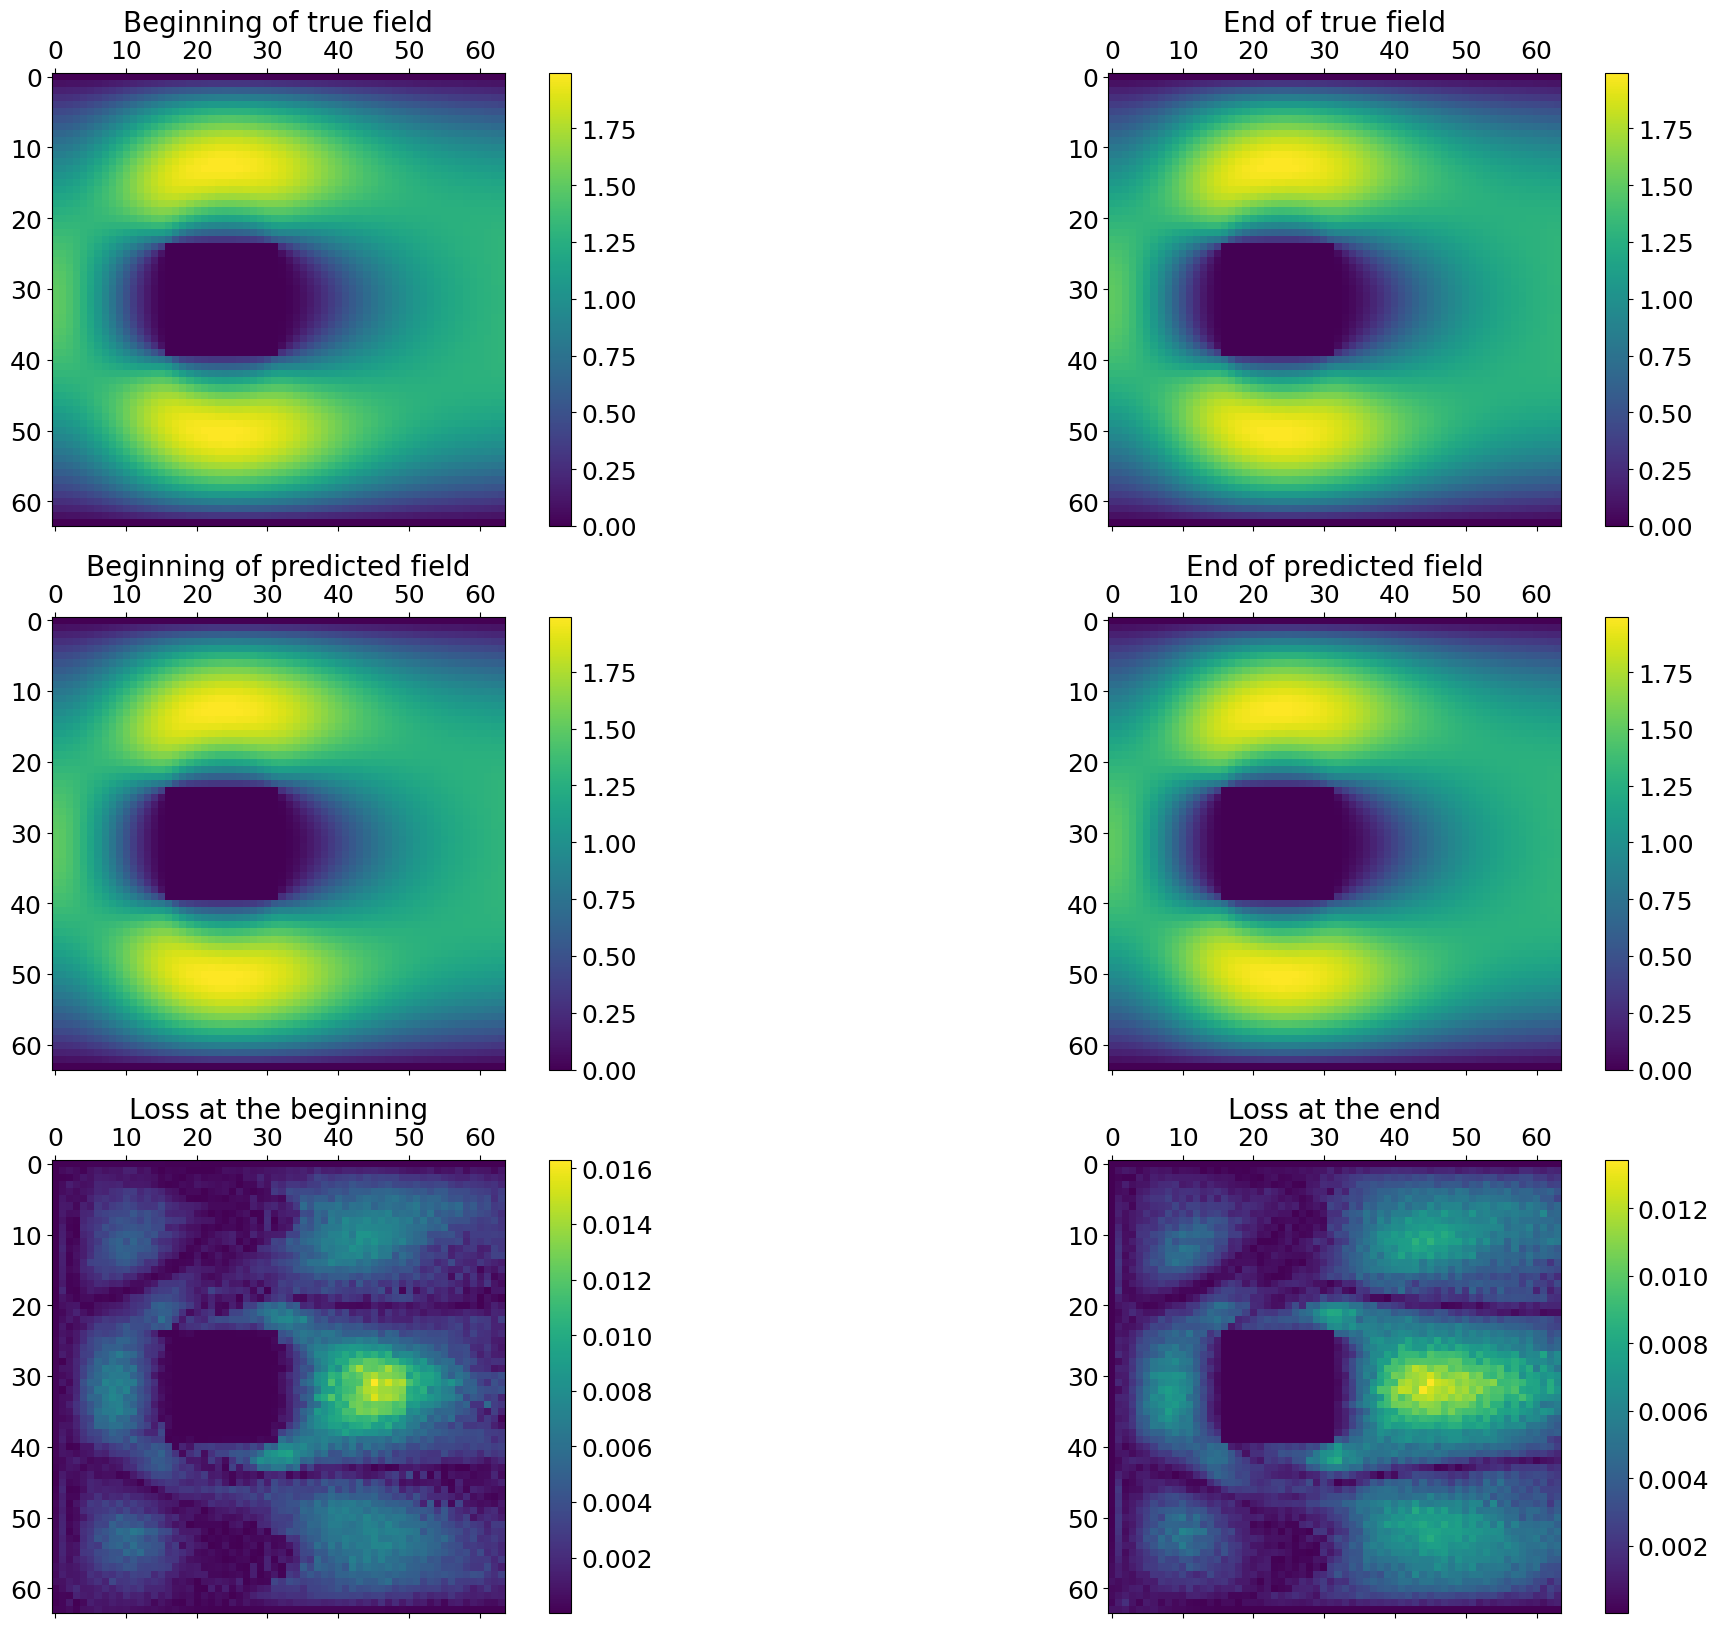

In [37]:
plot_loss(x_test, predictions, test_u, 49, 39)

In [25]:
norm_loss, mean, std = find_loss(predictions, test_u, 0, 0)
norm_loss = norm_loss.cpu().detach().numpy()
noise = np.random.normal(0, std, norm_loss.shape)

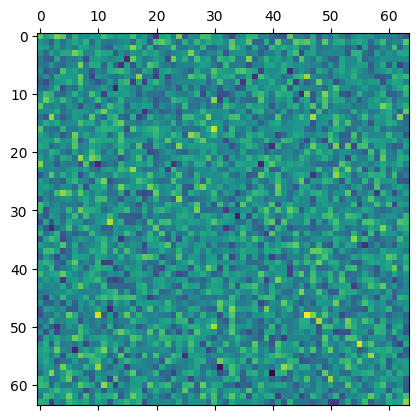

In [26]:
plt.matshow(noise)

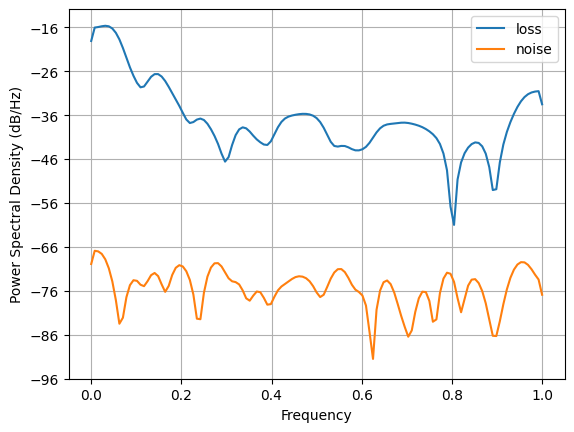

In [27]:
plt.psd(norm_loss, label = 'loss')
plt.psd(noise, label = 'noise')
plt.legend()

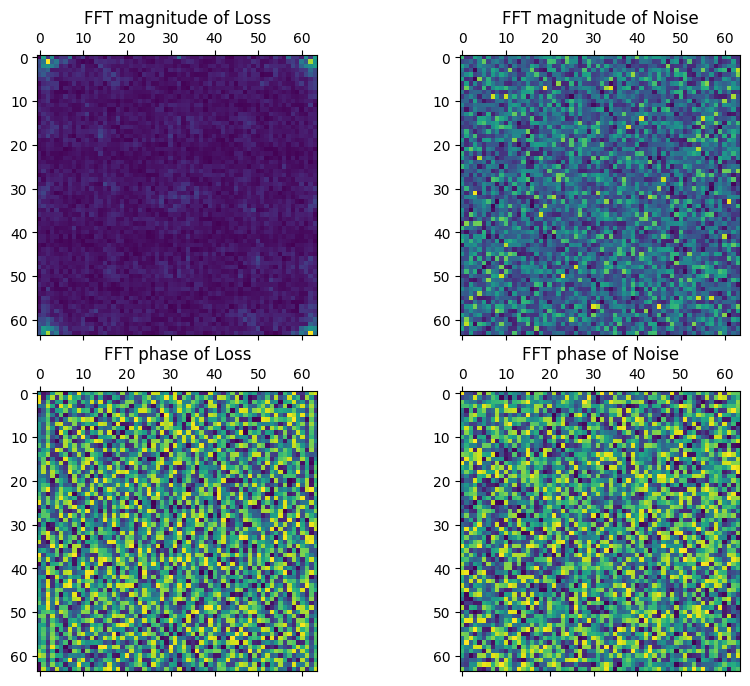

In [28]:
psd1 = np.fft.fft2(norm_loss, norm = 'ortho')
psd2 = np.fft.fft2(noise, norm = 'ortho')

# plt.matshow(np.abs(psd2))
# plt.matshow(np.angle(psd2))



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax[0,0].matshow(np.abs(psd1))
ax[0,0].set_title('FFT magnitude of Loss')
ax[0,1].matshow(np.abs(psd2))
ax[0,1].set_title('FFT magnitude of Noise')
ax[1,0].matshow(np.angle(psd1))
ax[1,0].set_title('FFT phase of Loss')
ax[1,1].matshow(np.angle(psd2))
ax[1,1].set_title('FFT phase of Noise')
plt.show()


# plt.plot(psd1[0], label = 'loss')
# plt.plot(psd2[0], label = 'noise')
# plt.legend()

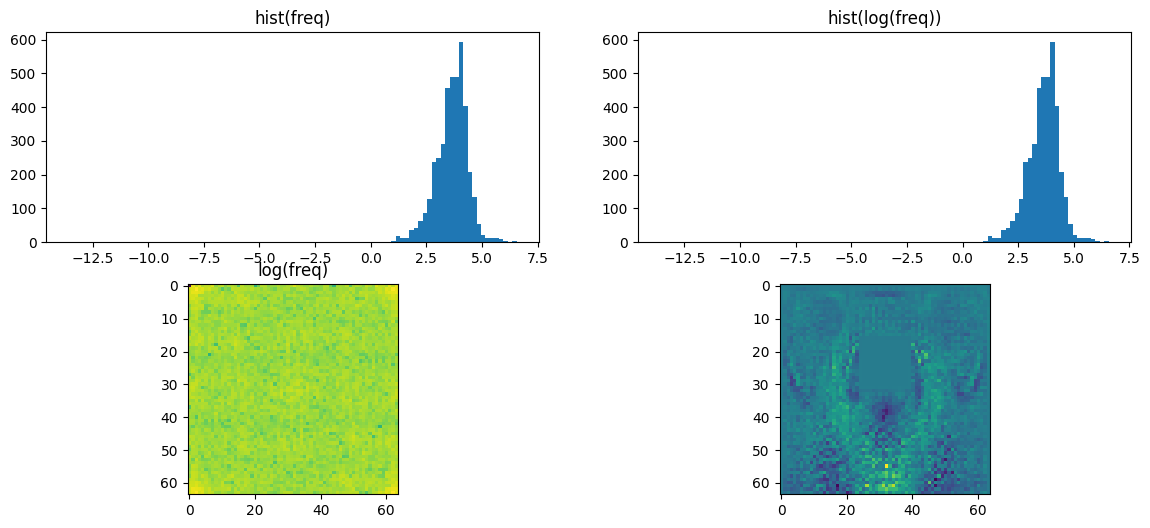

In [29]:
# file_path = "data"
# image = np.asarray(Image.open(file_path).convert('L'))
# freq = np.fft.fft2(image)
# freq = np.abs(freq)

freq = np.fft.fft2(norm_loss)
freq = np.abs(freq)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
ax[0,0].hist(np.log(freq.ravel()), bins=100)
ax[0,0].set_title('hist(freq)')
ax[0,1].hist(np.log(freq).ravel(), bins=100)
ax[0,1].set_title('hist(log(freq))')
ax[1,0].imshow(np.log(freq), interpolation="none")
ax[1,0].set_title('log(freq)')
ax[1,1].imshow(norm_loss, interpolation="none")
plt.show()

In [30]:
# test_l2 = test(model, test_loader, device, lossFn=myloss, post_proc=y_normalizer.decode)
# test_l2

In [31]:
# tns = predictions
# for set in range(tns.shape[0]):
#     makeVid(tns, set, 'animations/NS/ns_V1e-3_N5000_T50/predictions')

In [32]:
# tns = test_u
# for set in range(tns.shape[0]):
#     makeVid(tns, set, 'animations/NS/ns_V1e-3_N5000_T50/test')